<a href="https://colab.research.google.com/github/AlbertPangilinan/SEP740/blob/main/Copy_of_740_vgg_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from skimage import io
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib. pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
input_paths = '/content/drive/MyDrive/archive/dataset/semantic_drone_dataset/original_images'
output_paths = '/content/drive/MyDrive/archive/RGB_color_image_masks/RGB_color_image_masks'
sematic_paths = '/content/drive/MyDrive/archive/dataset/semantic_drone_dataset/label_images_semantic'

images_paths = os.listdir(input_paths)
labels_paths = os.listdir(output_paths)
sLabels_paths = os.listdir(sematic_paths)

images_paths.sort()
labels_paths.sort()
sLabels_paths.sort()

images_list = [os.path.join(input_paths,i) for i in images_paths]
labels_list = [os.path.join(output_paths,i) for i in labels_paths]
sLabels_list = [os.path.join(sematic_paths,i) for i in sLabels_paths]

In [ ]:
images_names  = tf.constant(images_list)
labels_names = tf.constant(labels_list)
sLabels_names = tf.constant(sLabels_list)

dataset = tf.data.Dataset.from_tensor_slices((images_names,labels_names,sLabels_names))

In [ ]:
#Load images and labels
def load_img_lab(img_path, lab_path, slab_path):
    images = tf.io.read_file(img_path)
    #print(images)
    #print(type(images))
    images = tf.image.decode_png(images)
    #print('images shape is: ', images.shape)
    images = tf.image.convert_image_dtype(images,tf.float32)
    #print('images after is: ', np.array(images))

    labels = tf.io.read_file(lab_path)
    labels = tf.image.decode_png(labels)
    labels = tf.image.convert_image_dtype(labels,tf.float32)
    
    semantics = tf.io.read_file(slab_path)
    semantics = tf.image.decode_png(semantics)
    semantics =  tf.image.convert_image_dtype(semantics,tf.float32)

    return images, labels, semantics

#Resize iamges and labels
def resize(image, label, sLabel):
    input_images = tf.image.resize(image,(80,120),method='nearest')
    input_labels = tf.image.resize(label,(80,120),method='nearest')
    input_semantics = tf.image.resize(sLabel,(120,80),method='nearest')

    return input_images,input_labels,input_semantics

In [ ]:
import PIL
from PIL import Image

# loading the image
img = PIL.Image.open(images_list[0])

# fetching the dimensions
wid, hgt = img.size

# displaying the dimensions
print(str(wid) + "x" + str(hgt))

6000x4000


<class 'tensorflow.python.framework.ops.EagerTensor'>
sem is:  [[[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.00392157]
  [0.00392157]
  [0.00392157]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.00392157]
  [0.00392157]
  [0.00392157]]

 ...

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]]
type is:  <class 'tensorflow.python.framework.ops.EagerTensor'>
toarray is:  (4000, 6000, 1)
sem matrix is:  <PIL.Image.Image image mode=L size=6000x4000 at 0x7FBA694F0A10>


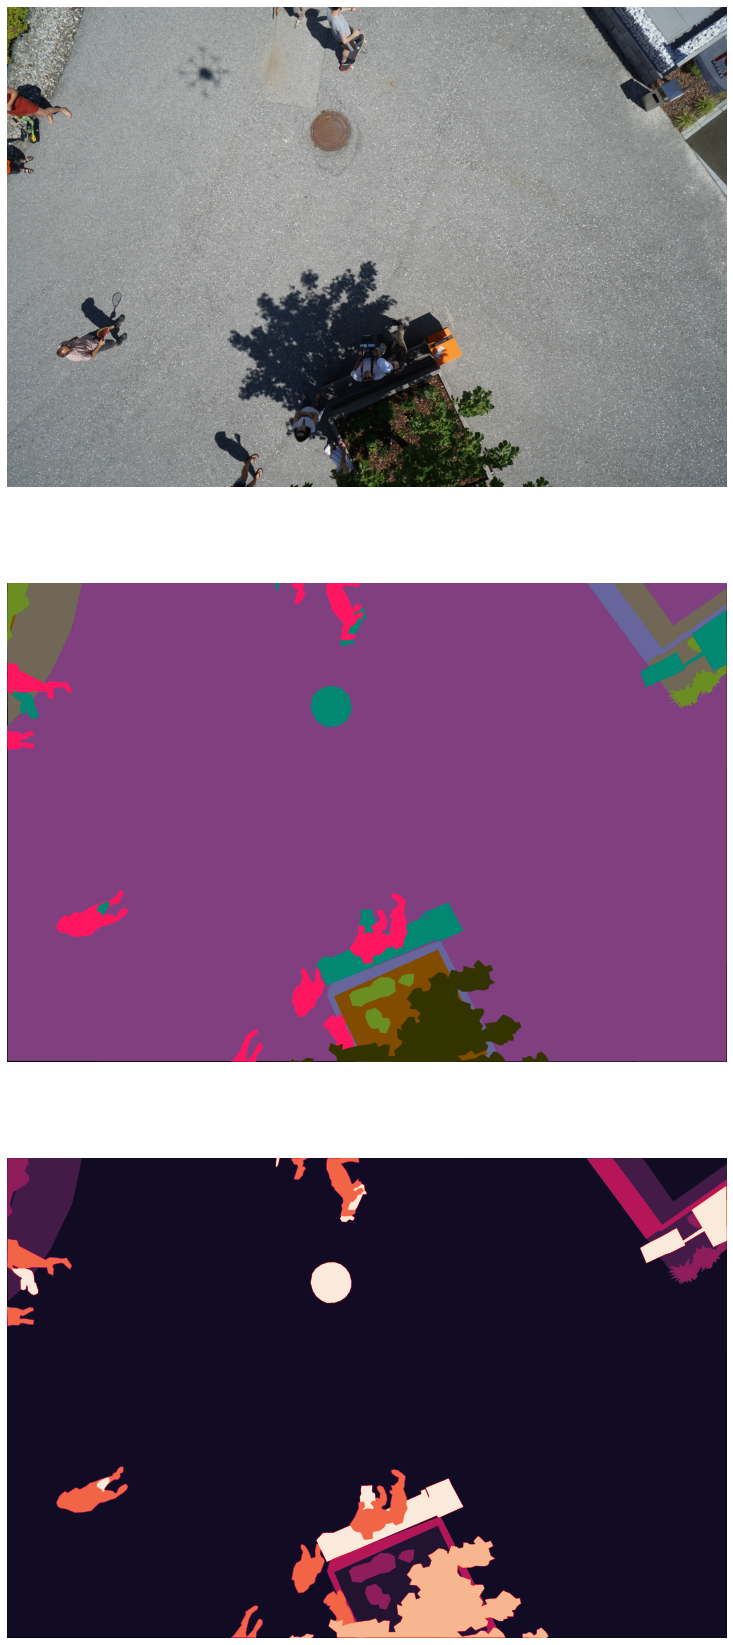

In [ ]:
imgs_labs = dataset.map(load_img_lab)
#resized_imgs_labs = imgs_labs.map(resize)
for img, lab, sem in imgs_labs.take(1):
    print(type(img))
    _, axis = plt.subplots(3,1,figsize=(30,30))
    print('sem is: ', np.array(sem))
    print('type is: ', type(img))
    print('toarray is: ',np.array(sem).shape)
    axis[0].imshow(tf.keras.preprocessing.image.array_to_img(img))
    axis[0].axis('off')
    axis[1].imshow(tf.keras.preprocessing.image.array_to_img(lab))
    axis[1].axis('off')
    axis[2].imshow(tf.keras.preprocessing.image.array_to_img(sem))
    print('sem matrix is: ',tf.keras.preprocessing.image.array_to_img(sem))
    axis[2].axis('off')

In [ ]:
import os
import cv2
import glob
import pickle
import numpy as np
import pandas as pd
from keras.layers import Conv2D
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [ ]:
#We apply VGG16 model without fully connected layers
#Applying imagenet weights as feature generators
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(80, 120, 3))

#We use pre-trained weights and we make layers of VGG16 as non-trainable. 
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 120, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 80, 120, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 80, 120, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 40, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 40, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 40, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 20, 30, 128)       0     

In [ ]:
#On consideration of easy comparison to labels we apply the first 2 layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 120, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 80, 120, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 80, 120, 64)       36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [ ]:
train_images = []
train_masks = []
i=0
for img, lab, sem in resized_imgs_labs.take(400):
    print(i)
    train_images.append(np.array(img))
    #print('dim is:',np.array(sem).shape)
    train_masks.append(np.squeeze(np.array(sem)))
    i+=1

In [ ]:
print(img.shape)

(80, 120, 3)


In [ ]:
X_train = np.array(train_images)
y_train = np.array(train_masks)

In [ ]:
#Now, let us apply feature extractor to our training data
features=new_model.predict(X_train)

13/13 [==============================] - 8s 18ms/step


In [ ]:
print(features.shape)

(400, 80, 120, 64)


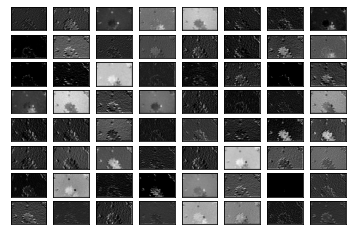

In [ ]:
#Plot features to view
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray',aspect='auto')
        ix +=1
plt.show()

In [ ]:
X=features
X = X.reshape(-1, X.shape[3])
Y = y_train.reshape(-1)

dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

[0.03137255 0.01568628 0.00392157 0.05882353 0.03921569 0.08627451
 0.00784314 0.07450981 0.0509804  0.08235294 0.01176471 0.05490196
 0.         0.03529412 0.07843138 0.04313726 0.04705883 0.07058824
 0.06666667 0.02352941 0.01960784 0.0627451  0.02745098]
0.003922    1450580
0.011765     768433
0.035294     283569
0.015686     280917
0.031373     273543
0.086275     136396
0.007843     123085
0.039216     103520
0.019608      85228
0.074510      79041
0.078431      51320
0.058824      40402
0.050980      36875
0.066667      30269
0.023529      27665
0.027451      24600
0.043137      21546
0.082353       8762
0.070588       8328
0.000000       2101
0.054902       2053
0.047059       1219
0.062745        548
Name: Label, dtype: int64


In [ ]:
#drop rows of dataset whose label is 0
dataset = dataset[dataset['Label'] != 0]
from sklearn import preprocessing

X_for_rf = dataset.drop(labels = ['Label'], axis=1)
Y_for_rf = dataset['Label']
Y_for_rf = preprocessing.LabelEncoder().fit_transform(Y_for_rf)

X_train, X_test, y_train, y_test = train_test_split(X_for_rf, Y_for_rf, test_size=0.3, random_state=20)

print(X_train)
print(y_train)

               0         1         2         3          4         5   \
3274299  0.825595  0.693221  0.926612  2.571286  14.429961  0.438763   
2901424  1.252131  1.998398  0.380595  5.203017  10.481357  0.791626   
2847583  3.984161  1.602786  1.655435  2.220608  10.338305  1.166276   
384231   0.000000  0.787701  1.874983  3.987402  10.677366  0.296675   
642403   4.322125  3.724554  1.914276  5.343029  12.000095  1.307496   
...           ...       ...       ...       ...        ...       ...   
556691   0.732202  0.841018  0.878548  1.356406   5.801467  0.000000   
1335389  0.915350  0.634305  1.195609  2.269130  12.573327  0.377108   
1086559  4.308115  3.334829  2.183615  5.173337  11.921317  1.167011   
2977915  2.483948  1.545822  0.547953  7.308963  11.445866  0.000000   
1032309  0.989204  1.231063  1.654755  3.531942  10.667937  5.711088   

               6         7         8         9   ...   54        55        56  \
3274299  1.641138  0.048443  0.000000  1.721700  ...  

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 5, criterion='gini', min_samples_split =2, max_features = 'sqrt', random_state = 15)

model.fit(X_train, y_train) 

RandomForestClassifier(max_features='sqrt', n_estimators=5, random_state=15)

In [ ]:
prediction_test = model.predict(X_test)

from sklearn import metrics
#Print the prediction accuracy
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))

Accuracy =  0.6684419430765088


#Fine tuning with grid search

In [ ]:
def create_vgg16_rf_model(n_estimators = 5, criterion='gini', min_samples_split =2, max_features = 'sqrt', random_state = 15):
  model = RandomForestClassifier(n_estimators = 5, random_state = 15)
  return model

In [ ]:
# create model
model_1 = KerasClassifier(build_fn=create_vgg16_rf_model, verbose=1)
# define parameters and values for grid search 
param_grid = {
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_features':['sqrt', 'log2']
}

#grid = GridSearchCV(estimator=model_1, param_grid=param_grid, cv=5)
#grid_result = grid.fit(X_train, y_train)

# summarize results
#display_cv_results(grid_result)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
# Build the grid search
dfrst = create_vgg16_rf_model()
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
grid_results = grid.fit(X_train, y_train)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)
results_df

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/para

Best: [0.66471793 0.66278533 0.66696135 0.66475106        nan        nan], using {'criterion': 'entropy', 'max_features': 'sqrt'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,301.523945,7.074678,2.664524,0.086121,gini,sqrt,"{'criterion': 'gini', 'max_features': 'sqrt'}",0.665046,0.664465,0.664835,0.664377,0.664866,0.664718,0.000254,3
1,220.412974,2.290479,2.624450,0.057538,gini,log2,"{'criterion': 'gini', 'max_features': 'log2'}",0.662563,0.662267,0.663382,0.662451,0.663264,0.662785,0.000450,4
2,791.700957,11.182678,2.109463,0.114050,entropy,sqrt,"{'criterion': 'entropy', 'max_features': 'sqrt'}",0.666929,0.666750,0.666909,0.667164,0.667055,0.666961,0.000140,1
3,592.206702,6.989323,2.070147,0.042416,entropy,log2,"{'criterion': 'entropy', 'max_features': 'log2'}",0.665003,0.664463,0.665051,0.664564,0.664675,0.664751,0.000236,2
4,0.764162,0.003863,0.000000,0.000000,log_loss,sqrt,"{'criterion': 'log_loss', 'max_features': 'sqrt'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
5,0.775889,0.014893,0.000000,0.000000,log_loss,log2,"{'criterion': 'log_loss', 'max_features': 'log2'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,6


In [ ]:
def display_cv_results(search_results):
    print('Best score = {:.4f} using {}'.format(search_results.best_score_, search_results.best_params_))
    means = search_results.cv_results_['mean_test_score']
    stds = search_results.cv_results_['std_test_score']
    params = search_results.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print('mean test accuracy +/- std = {:.4f} +/- {:.4f} with: {}'.format(mean, stdev, param))

In [ ]:
display_cv_results(grid_results)

Best score = 0.6670 using {'criterion': 'entropy', 'max_features': 'sqrt'}
mean test accuracy +/- std = 0.6647 +/- 0.0003 with: {'criterion': 'gini', 'max_features': 'sqrt'}
mean test accuracy +/- std = 0.6628 +/- 0.0005 with: {'criterion': 'gini', 'max_features': 'log2'}
mean test accuracy +/- std = 0.6670 +/- 0.0001 with: {'criterion': 'entropy', 'max_features': 'sqrt'}
mean test accuracy +/- std = 0.6648 +/- 0.0002 with: {'criterion': 'entropy', 'max_features': 'log2'}
mean test accuracy +/- std = nan +/- nan with: {'criterion': 'log_loss', 'max_features': 'sqrt'}
mean test accuracy +/- std = nan +/- nan with: {'criterion': 'log_loss', 'max_features': 'log2'}
